In [1]:
import numpy as np
import math 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

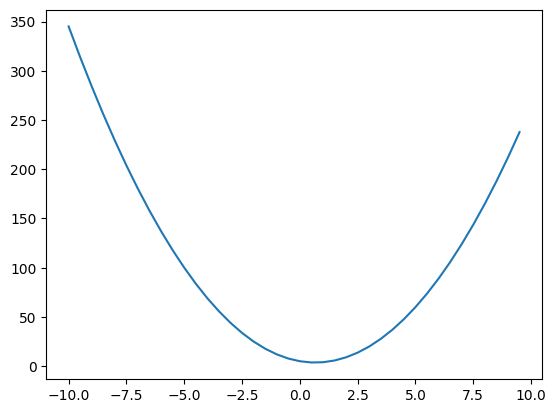

In [3]:
x_axis = np.arange(-10,10,0.5)
y_axis = f(x_axis)
plt.plot(x_axis,y_axis)

### understanding derivatives
- so lets find the derivative of f(x) at x = -5, both numerically and analytically
- we know that f'(x) = 6x - 4
    - so the derivative of f(x) at -5 is 6(-5) - 4 = -34
- numerically, derivative is:
    f(x-h) - f(x) / h as limit h->0
    - so the derivative at -5 can be calculated by selecting a small value of h
    - h = 0.0001 



In [4]:
h = 0.000001
x = -5
deriv = lambda x: (f(x+h) - f(x))/h
deriv(x)

-33.999997000933035

### now, lets continue with multivariable functions, and use the chain rule using partial derivatives.

In [5]:
# say we got chain of 3 equations
a = 3
b = 4
c = -5
d = a*b + c
d
# here we want to find the derivative of d with respect to a, b and c

7

In [6]:
f = lambda a, b, c: a*b + c
h = 0.000001
a = 3
b = 4
c = -5
d1 = f(a, b, c)
a += h # differencial increase in a
#b += h # differencial increase in b
#c += h # differencial increase in c
d2 = f(a, b, c)

deriv = (d2 - d1)/h # slope is normalized by h
deriv

4.000000000559112

In [7]:
# lets define another function, but a more composite one.

f = lambda d,e : d*e # -4c*6 = -4(a*b)*6
# to find df/da we can use the chain rule : df/da = df/dd * dd/dc * dc/da = -4*b*6
h = 0.000001
a = 3
b = 4
c = a*b
d = -4*c
e = 6
d1 = f(d,e)


a = 3
b = 4
a += h
#b += h
c = a*b
#c += h
d = -4*c
#d += h
e = 6
#e += h

d2 = f(d,e)

deriv = (d2 - d1)/h # slope is normalized by h
deriv

-95.99999998499698

### now lets build our Value Class 

In [28]:
class Value:
    def __init__(self, value, _children=(), _ops='', label=''):
        self.value = value
        self._prev = set(_children)
        self._op = _ops
        self.label = label
        self.grad = 0.0

    def __repr__(self) -> str:
        return f"Value(value={self.value})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return Value(self.value + other.value, (self, other), '+')

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return Value(self.value * other.value, (self, other), '*')

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        if other.value == 0:
            raise ValueError("Cannot divide by zero")
        return Value(self.value / other.value, (self, other), '/')

    def __rtruediv__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        if self.value == 0:
            raise ValueError("Cannot divide by zero")
        return Value(other.value / self.value , (other,self), '/')
    

    def tanh(self):
        """
        (e^2x-1)/(e^2x+1)
        """
        x = self.value
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        print(out)
        return out
    
    def relu(self):
        return Value(max(0, self.value), (self, ), 'relu')

In [22]:
val1 = Value(1)
val2 = Value(2)
val1 * val2 

Value(value=2)

### now create a graph visualization code to visualize our chained representations

In [23]:
from graphviz import Digraph

def trace(root):
    """
    Build the topography of the computational graph.
    """
    nodes, edges = set(), set() # set of all nodes and edges in our graph
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child) # recursively build the graph
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left to right
    nodes, edges = trace(root) # get the tapography
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.value, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


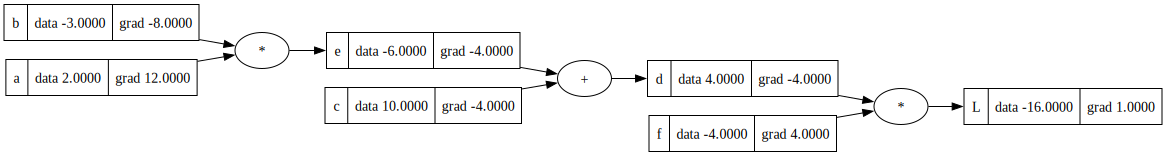

In [15]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b ; e.label = 'e'
d = e + c ; d.label = 'd'
f = Value(-4.0, label='f')
L = d*f ; L.label = 'L';L.grad = 1 # will represent the final calculated loss 
# here other gradients are : a.grad = 12, b.grad = -8, c.grad = -4, e.grad = -4, d.grad = -4, f.grad = 4
a.grad = 12
b.grad = -8
c.grad = -4
e.grad = -4
d.grad = -4
f.grad = 4
draw_dot(L)


In [17]:
h = 0.001

In [19]:
# if you icrease a & f values in direction of gradient, it will decrease the loss
a = Value(2.0+h, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b ; e.label = 'e'
d = e + c ; d.label = 'd'
f = Value(-4.0+h, label='f')
L = d*f ; L.label = 'L'; L.grad = 1
L # we expect higher L, means less negative L

Value(value=-15.984003)

- so, we visualized a simple forward pass of our function
- we now know how to influence the final outcome:loss via our node gradients and the chain rule. 
- now we would like to run backpropagation:
    - start at the end, L
    - go reverse and calculate the gradient along all the intermediate nodes
        - for every single node value, we are going to compute the derivative of that node wrt the loss L
    - in neural network settings, we would be very interested in the gradient of the loss wrt the weights and biases of the network. some of these nodes will represent trainable parameters(w,b), and some will represent the actual training data which is fixed.
    - we need a variable inside our Value class, that maintains the gradient value wrt the loss.
- we just go through recursively and multiply on the local derivatives of each node. so its just a recursive application of chain rule.

### now, we apply backpropagation on a modeled single neuron
- having: weights associated with it, bias and an activation function applied to its output, in forward pass.  

### activation function: tanh

Value(value=0.7071067811865476)


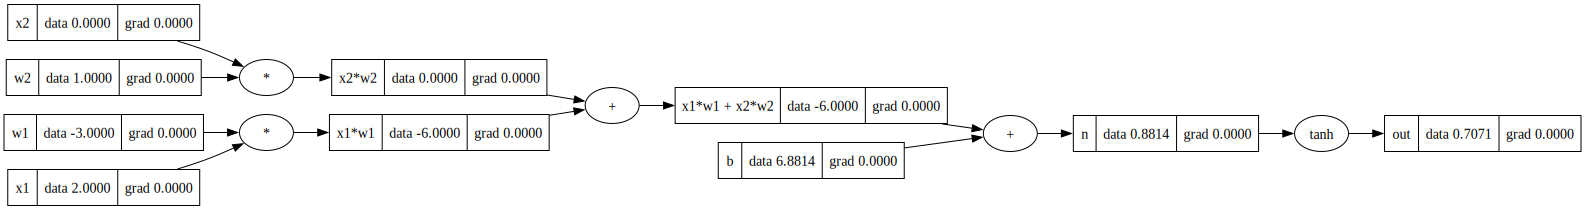

In [46]:
### all weights, biases and their products are simply Value objects
# input values
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b') # to produce a nice-looking output
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
out = n.tanh(); out.label = 'out'
draw_dot(out)

### another activation function: ReLU

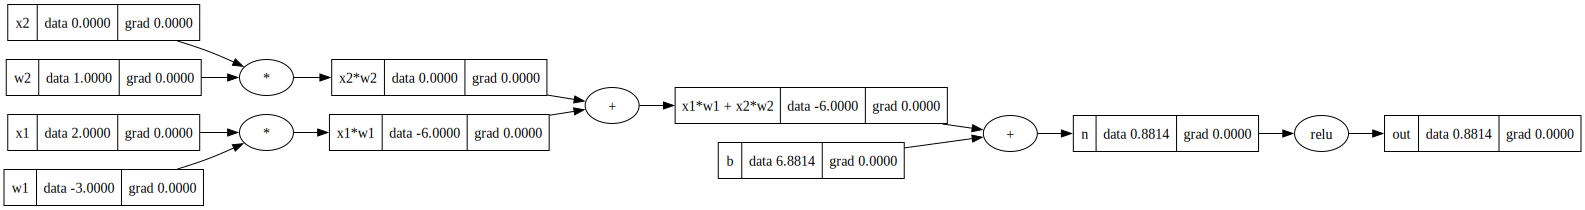

In [32]:
# input values
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b') # to make sure numbers come out nicely
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
out = n.relu(); out.label = 'out'
draw_dot(out)

##### now lets backpropagate this single nueron manually

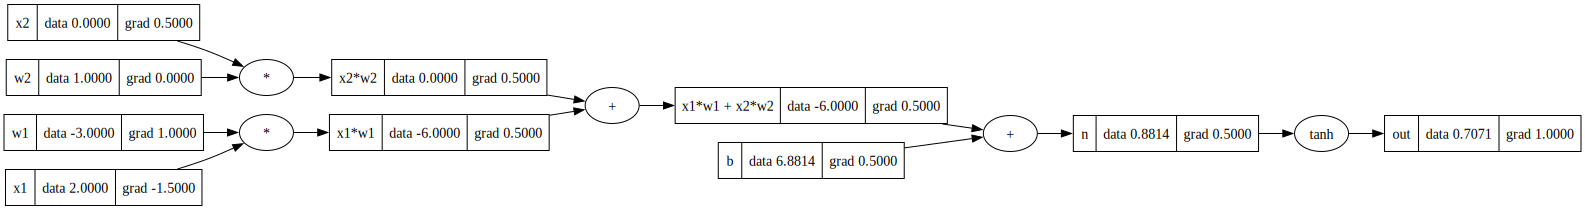

In [48]:
draw_dot(out)

In [47]:
out.grad = 1.0
# tanh: we need to find the local derivative for tanh which is given as 
# 1 - tanh^2
# out = tanh(n) so dout/dn = 1 - tanh(n)^2 = 1- out^2
n.grad = (1- out.value**2)*out.grad

# + is distributer of local gradient
x1w1x2w2.grad = n.grad
b.grad = n.grad

x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

#  * is multiplier of gradients
x1.grad = x1w1.grad*w1.value
x2.grad = x2w2.grad*w2.value
w1.grad = x1w1.grad*x1.value
w2.grad = x2w2.grad*x2.value

##### we now know how a tiny change in input will influence the output
- we need to implement the backward function for each operation in our Value class

In [61]:
class Value:
    def __init__(self, value, _children=(), _ops='', label=''):
        self.value = value
        self._prev = set(_children)
        self._op = _ops
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None # initialize as function, for leaf
        # node there is nothing to do, so initialize as None

    def __repr__(self) -> str:
        return f"Value(value={self.value}, name={self.label})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.value + other.value, (self, other), '+')
        def backward():
            # distribute the gradient to all inputs
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        out._backward = backward 
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.value * other.value, (self, other), '*')
        def backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad
        out._backward = backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        if other.value == 0:
            raise ValueError("Cannot divide by zero")
        return Value(self.value / other.value, (self, other), '/')

    def __rtruediv__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        if self.value == 0:
            raise ValueError("Cannot divide by zero")
        return Value(other.value / self.value , (other,self), '/')
    

    def tanh(self):
        """
        (e^2x-1)/(e^2x+1)
        """
        x = self.value
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = backward
        return out
    
    def relu(self):
        out = Value(max(0, self.value), (self, ), 'relu')
        def backward():
            self.grad += (out.value > 0) * out.grad
        out._backward = backward
        return out

In [69]:
### all weights, biases and their products are simply Value objects
# input values
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b') # to produce a nice-looking output
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
out = n.tanh(); out.label = 'out'


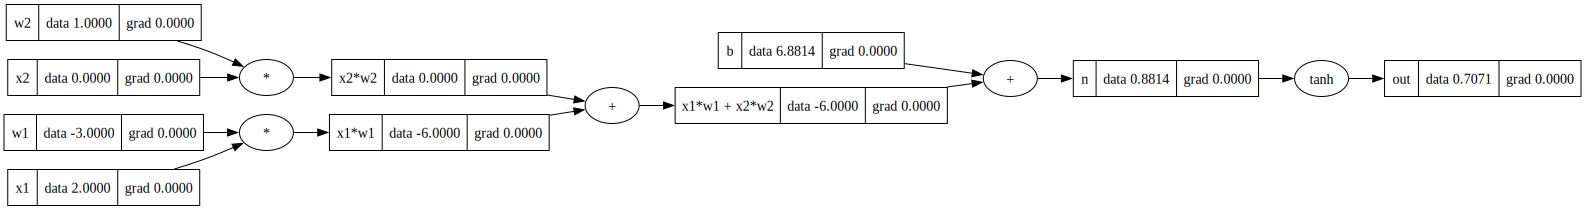

In [63]:
draw_dot(out)

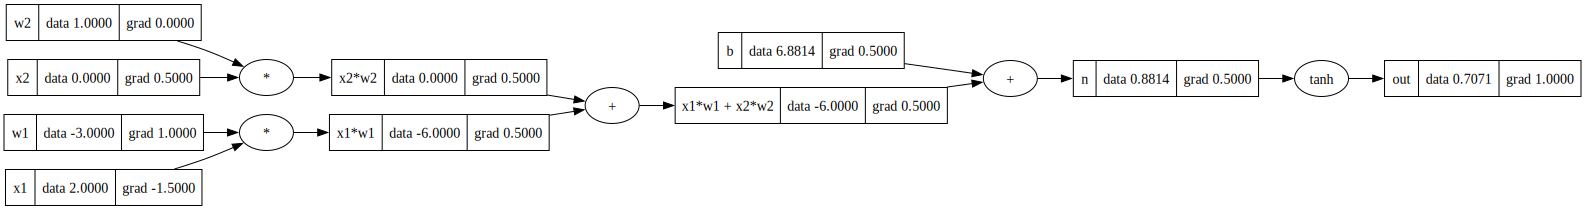

In [64]:
out.grad = 1.0
out._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
x1._backward()
x2._backward()
w1._backward()
w2._backward()
draw_dot(out)

### fully autonomous backprop
- now we layed out the full computational grap / expression, and want to go backwards through that expression, from output to input
- every node .backward should be called if its dependencies have .grad set
- this ordering of graph traversal can be achieved by **topological sort**


In [70]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(out)
list(reversed(topo)) 

[Value(value=0.7071067811865476, name=out),
 Value(value=0.8813735870195432, name=n),
 Value(value=6.881373587019543, name=b),
 Value(value=-6.0, name=x1*w1 + x2*w2),
 Value(value=0.0, name=x2*w2),
 Value(value=0.0, name=x2),
 Value(value=1.0, name=w2),
 Value(value=-6.0, name=x1*w1),
 Value(value=-3.0, name=w1),
 Value(value=2.0, name=x1)]

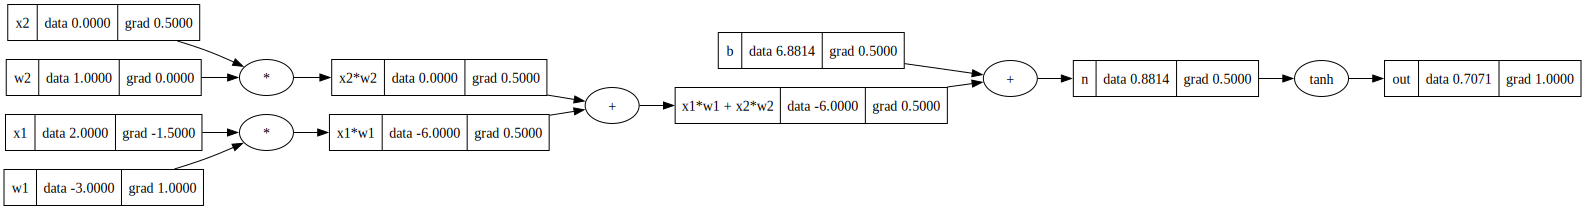

In [71]:
# first out.grad = 1
out.grad = 1.0

for node in reversed(topo):
    node._backward()

draw_dot(out)

### now include this auto backward in Value Class 

In [186]:
class Value:
    def __init__(self, value, _children=(), _ops='', label=''):
        self.value = value
        self._prev = set(_children)
        self._op = _ops
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None # initialize as function, for leaf
        # node there is nothing to do, so initialize as None

    def __repr__(self) -> str:
        return f"Value(value={self.value}, name={self.label})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.value + other.value, (self, other), '+')
        def backward():
            # distribute the gradient to all inputs
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        out._backward = backward 
        return out

    def __radd__(self, other):
        """
        if other does not know how to __add__(self), the self will try.
        """
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.value * other.value, (self, other), '*')
        def backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad
        out._backward = backward
        return out

    def __rmul__(self, other):
        """
        if other does not know how to __mull__(self), the self will try.
        """
        return self * other

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        if other.value == 0:
            raise ValueError("Cannot divide by zero")
        return Value(self.value / other.value, (self, other), '/')

    def __rtruediv__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        if self.value == 0:
            raise ValueError("Cannot divide by zero")
        return Value(other.value / self.value , (other,self), '/')
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.value**other, (self, ), f'**{other}')
        def backward():
            self.grad += (other * self.value ** (other - 1)) * out.grad
        out._backward = backward
        return out
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)

    def tanh(self):
        """
        More stable tanh function using numpy for better large input handling.
        """
        x = self.value
        t = np.tanh(x)  # numpy's tanh is used here for stability
        out = Value(t, (self,), 'tanh')

        def backward():
            # The gradient of tanh is (1 - tanh^2(x))
            self.grad += (1 - t**2) * out.grad
        out._backward = backward
        return out
    
    def relu(self):
        out = Value(max(0, self.value), (self, ), 'relu')
        def backward():
            self.grad += (out.value > 0) * out.grad
        out._backward = backward
        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

        
    

In [73]:
# input values
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b') # to produce a nice-looking output
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
out = n.tanh(); out.label = 'out'

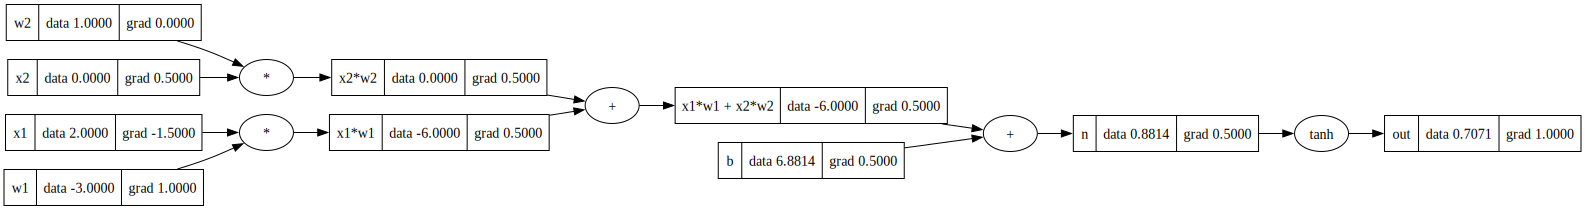

In [74]:
out.backward()
draw_dot(out)

#### now lets build out our Neuron Class , with dimensions provided
- we already created our Value Class, representing each trainable value object

In [143]:
import random


class Neuron:
    def __init__(self, nin):
        """
        nin: how many connections
        """
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self,x):
        # forward pass like n1 = Neuron(3), n1(x) as we do with tensorflow and pytorch
        # 1. iterate thru tuples generated from 2 iterables via zip, add bias 
        # first ensure self.w and x are same length(dimensions), if not raise error
        if len(self.w) != len(x):
            raise ValueError(f"expected {len(self.w)} inputs, got {len(x)}")
        act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        out = act.tanh() # non-linearity introduced
        return out
    
    def parameters(self):
        return self.w + [self.b] # list of [w,b]'s



In [94]:
neuron = Neuron(3)
x = [2.0, 3.0, 4.0]
y = neuron(x)
y

Value(value=0.6923500356247079, name=)

### now lets build our Layer of neurons Class

In [142]:
class Layer:
    """
    - just a list of neurons
    - does have input and ouput layers connected
    - nin: neuron 
    """
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # if single output , return as scalar, else return list
    
    def parameters(self,):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params


In [98]:
l1 = Layer(4,3)
x = [2.0, 3.0, 4.0, 5.0]
l1(x)

[Value(value=-0.9999999999443676, name=),
 Value(value=-0.9938605663279665, name=),
 Value(value=0.7429854391453111, name=)]

### now lets build out MLP class : a list of layers

In [145]:
class MLP:
    """
    - nin: input X dimension, len(list of scalars)
    - nouts: dimension of each layer, provided as list
    """
    def __init__(self, nin, nouts):
        sz = [nin] + nouts # will produce list of sizes
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # to match the dimensions of consecutive layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [106]:
mlp = MLP(3, [4, 4, 1]) # 3 inputs, layers: 4, 4, 1
x = [2.0, 3.0, 4.0] # 3 inputs
y_hat = mlp(x) # produces 1 scalar output

In [ ]:
draw_dot(y_hat)

### now we have a fully connected neural network, ready to be trained. lets create a sample dataset, along with target labels

In [161]:
mlp = MLP(5, [4, 4, 1]) # 3 inputs, layers: 4, 4, 1
X_train = [
    [2.0, 3.0, 4.0, 5.0,3.0],
    [3.0, 4.0, 5.0, 6.0,4.0],
    [4.0, 5.0, 6.0, 7.0,5.0],
    [5.0, 6.0, 7.0, 8.0,6.0],
    [6.0, 7.0, 8.0, 9.0,7.0]]

y_train = [1.0, -1.0, 1.0, -1.0, 1.0] # binary classification task
y_preds = [mlp(x) for x in X_train]
y_preds

[Value(value=0.770713026849369, name=),
 Value(value=0.7711956768478653, name=),
 Value(value=0.7715196755212763, name=),
 Value(value=0.7717360408445663, name=),
 Value(value=0.771880418188838, name=)]

In [162]:
len(mlp.parameters()) # 49 params

49

In [163]:
### lets define the loss , use mse
loss = sum((y-y_pred) ** 2 for y_pred, y in zip(y_preds, y_train))
loss 

Value(value=6.432997042448327, name=)

### we want to minimize this loss by applying gradient descent


In [174]:
loss.backward() # computes all gradients

In [171]:
mlp.layers[0].neurons[0].w[0].grad, mlp.layers[0].neurons[0].w[0].value

(-8.334184568621937e-06, 0.2997972929513209)

In [ ]:
draw_dot(loss)

#### we want to collect all the params, excluding the input grads then iterate through the params and update them

In [175]:
for p in mlp.parameters():
    p.value += -0.01 * p.grad # to minimize the loss



In [167]:
mlp.layers[0].neurons[0].w[0].grad,mlp.layers[0].neurons[0].w[0].value

(-4.924761025072699e-06, 0.2997972929513209)

In [176]:
y_preds = [mlp(x) for x in X_train]
loss = sum((y-y_pred) ** 2 for y_pred, y in zip(y_preds, y_train))
loss 

Value(value=4.95899713475579, name=)

### so here we have all the components for gradient descent
- in training loop:

    - compute the loss 

    - loss.backward() # updating the gradients

    - updating the params

In [205]:
import numpy as np

# Function to generate a sample learnable dataset
def generate_normalized_data(num_samples, num_features, num_classes):
    X = np.random.randn(num_samples, num_features)  # Random features
    # Normalize the features to have mean 0 and variance 1
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    true_weights = np.random.randn(num_features, num_classes)  # Random weights for our model
    noise = 0.1 * np.random.randn(num_samples, num_classes)  # Some noise
    
    # Generate targets: multiply features with weights and add noise
    Y = X.dot(true_weights) + noise
    
    # Apply a threshold to get binary class labels
    Y = np.where(Y > 0, 1, -1)
    
    return X, Y.squeeze()

# Generate a sample dataset with 5 features, 20 samples, and binary class labels
X_sample, Y_sample = generate_normalized_data(20, 5, 1)

X_train, y_train  = X_sample.tolist(), Y_sample.tolist()

In [206]:
(len(X_train),len(X_train[0])), len(y_train)

((20, 5), 20)

In [212]:
mlp = MLP(5, [5, 5, 1])
n_iters = 1000
learning_rate = 0.001
for i in range(n_iters):
    # forward pass
    y_preds = [mlp(x) for x in X_train]
    loss = sum((y-y_pred) ** 2 for y_pred, y in zip(y_preds, y_train))

    # reset gradients
    for p in mlp.parameters():
        p.grad = 0

    # backward pass
    loss.backward()

    # update
    for p in mlp.parameters():
        p.value += -learning_rate * p.grad
    
    if i % 100 == 0:
        print(f'Iteration: {i}, Loss: {loss.value}')

    # apply early stopping
    if loss.value < 0.01:
        print(f'Iteration: {i}, Loss: {loss.value}')
        break

Iteration: 0, Loss: 39.04767407934296
Iteration: 69, Loss: 0.008050734996026225
